## Version 5: use all the eyesclosed Microstates features.

In [1]:
cd ../pipelines

/Users/pldelacour/Documents/PL_Ecole/data_sc_lab/data_sc_lab/task_01/pipelines


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipynb.fs.full.tool_functions import *
from yellowbrick.regressor import AlphaSelection
from sklearn.metrics import mean_squared_error

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [3]:
df_beha = pd.read_csv('../../../data/Behavioral/AllData.csv')#, nrows=1000)

df_psd_cluster = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Cluster.csv") #, nrows=1000)
df_psd_channel = pd.read_csv("../../../data/EEG/RestingEEG_PSD_Channel.csv") #, nrows=5)
df_spectro_cluster = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Cluster.csv") #, nrows=1000)
df_spectro_channel = pd.read_csv("../../../data/EEG/RestingEEG_Spectro_Channel.csv") #, nrows=5)

df_microstate = pd.read_csv("../../../data/EEG/RestingEEG_Microstates.csv") #, nrows=5)

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (66,68,80,81,82,83,84,95,96,97,98,99,110,111,112,113,114,125,126,127,128,129,140,141,142,144,155,156,157,159,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,11

In [4]:
# Extract relevant info from the Behavioral data 
y_labels = df_beha[["Patient_ID", "Age", "DX_01_Cat"]]
y_labels_healthy = y_labels[y_labels["DX_01_Cat"].str.contains("No Diagnosis Given") == True]

y_labels = y_labels[["Patient_ID", "Age"]]
y_labels_healthy = y_labels_healthy[["Patient_ID", "Age"]]

In [5]:
df_psd_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_spectro_cluster.rename(columns={'id': 'Patient_ID'}, inplace=True)
df_microstate.rename(columns={'id': 'Patient_ID'}, inplace=True)
print("Original lengths: " + str(len(df_psd_cluster)) + "(psd), " + \
     str(len(df_spectro_cluster)) + "(spectro), " + str(len(df_microstate)) + "(micro)")

# Aggregate with label
df_label_psd_cluster = pd.merge(y_labels_healthy, df_psd_cluster, on='Patient_ID')
df_label_spectro_cluster = pd.merge(y_labels_healthy, df_spectro_cluster, on='Patient_ID')
df_label_microstate = pd.merge(y_labels_healthy, df_microstate, on='Patient_ID')
print("Only healthy people, resulting lengths: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

# Drop NaN values
df_label_psd_cluster = fill_with_median(df_label_psd_cluster)
df_label_spectro_cluster = fill_with_median(df_label_spectro_cluster)
df_label_microstate = fill_with_median(df_label_microstate)
print("Replace NaN by median, resulting lenghts: " + str(len(df_label_psd_cluster)) + "(psd), " + \
     str(len(df_label_spectro_cluster)) + "(spectro), " + str(len(df_label_microstate)) + "(micro)")

Original lengths: 1485(psd), 1485(spectro), 1108(micro)
Only healthy people, resulting lengths: 174(psd), 174(spectro), 128(micro)
Replace NaN by median, resulting lenghts: 174(psd), 174(spectro), 128(micro)


## Taking Only features for version 5

Version 5: use all the eyesclosed Microstates features.

In [6]:
df_label_microstate


col=  df_label_microstate.columns.str.contains('eyesclosed')
print("# of features = " , np.count_nonzero(col))
x_spev5 = df_label_microstate.loc[:,col]

y_train_df = df_label_microstate.loc[:,'Age']

# of features =  25


## Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
test_size = 0.2

In [9]:
x_train , x_test, y_train , y_test = train_test_split(x_spev5,y_train_df,test_size=test_size, random_state = 10)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(102, 25)
(26, 25)
(102,)


## Remove Outliers 

In [10]:
forest = IsolationForest()
forest.fit(x_train)

# Outlier indices for training
outliers_training = forest.predict(x_train)
outliers_training_indices = np.argwhere(outliers_training == 1).flatten()

# Drop signal outliers in training data
x_train = x_train[outliers_training == 1]
y_train = y_train[outliers_training == 1]

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(86, 25)
(86,)
(26, 25)
(26,)


## SVR

In [11]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
svr= SVR()
#svr = make_pipeline(StandardScaler(), SVR(C=1, epsilon= 0.2))
parameters = {'kernel' : ( 'rbf' , 'poly' ), 
              'C':[0.1, 1,10], 
              'gamma':['auto', 10e-2]}
clf = GridSearchCV(svr, parameters ,cv =3)
clf.fit(x_train , y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['auto', 0.1],
                         'kernel': ('rbf', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
y_pred_svr = clf.predict(x_test)
test_mse_svr = mean_squared_error(y_test ,y_pred_svr)
print('Test MSE SVR = ', test_mse_svr)

Test MSE SVR =  15.772803905357991


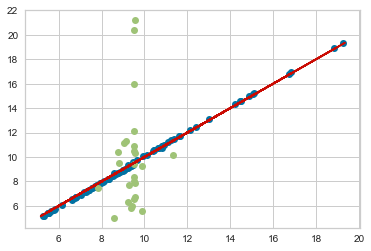

In [18]:
plt.plot(clf.predict(x_train) , y_train , 'o')
plt.plot(clf.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

## XG BOOST

In [19]:
from sklearn.model_selection import GridSearchCV
import sklearn
from xgboost import plot_importance
from matplotlib import pyplot

In [20]:
xg_boost = fit_xgboost_with_grid_search(x_train, y_train)

[22:54:19] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best parameters for XGBoost: {'max_depth': 2, 'min_child_weight': 16, 'reg_lambda': 10}


/Users/pldelacour/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [21]:
best_param = xg_boost.best_params_
xgbr = XGBRegressor(verbosity=1, 
                    max_depth=best_param['max_depth'], 
                    min_child_weight= best_param['min_child_weight'], 
                    reg_lambda=best_param['reg_lambda']) 
xgbr.fit(x_train, y_train)

[22:54:19] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=16, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [22]:
test_mse_xg = mean_squared_error(y_test , xgbr.predict(x_test))
print('TEST MSE = ', test_mse_xg)

TEST MSE =  14.475800495046615


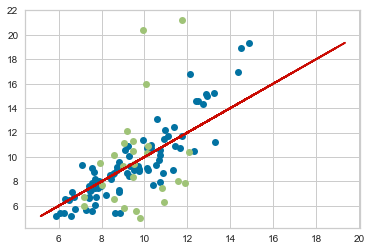

In [23]:
plt.plot(xgbr.predict(x_train) , y_train , 'o')
plt.plot(xgbr.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)

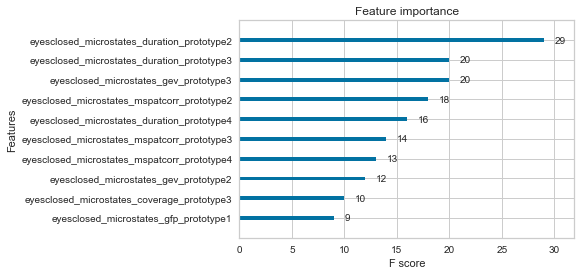

In [24]:
plot_importance(xgbr, max_num_features=10)
pyplot.show()

## Gaussian Process


In [25]:
gpr = GaussianProcessRegressor(n_restarts_optimizer=5)
    
# Grid search
parameters = {
    'kernel': [RationalQuadratic(), RBF(), Matern(length_scale=1, nu=1.5),  DotProduct()], 'alpha': [1e-10, 1e-5, 1e-3, 1e-1, 1., 1.5, 2.]}
clf_gp = GridSearchCV(gpr, parameters, scoring='r2', n_jobs=4, iid=False, cv=5)
clf_gp.fit(x_train, y_train)
clf_gp.best_params_

/Users/pldelacour/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/pldelacour/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


{'alpha': 0.001, 'kernel': DotProduct(sigma_0=1)}

In [26]:
y_pred_gp = clf_gp.predict(x_test)
test_mse_gp = mean_squared_error(y_test ,y_pred_svr)
print('Test MSE GP = ', test_mse_gp)

Test MSE GP =  15.772803905357991


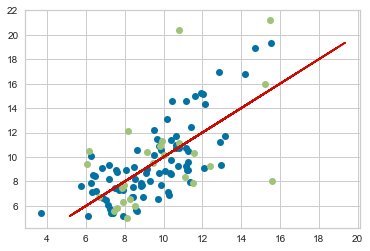

In [27]:
plt.plot(clf_gp.predict(x_train) , y_train , 'o')
plt.plot(clf_gp.predict(x_test), y_test , 'o')
plt.plot(y_train , y_train)